# All code needed to reproduce visualizations in the initial report

Note that throughout this report, we use the following appreviations:
- **Meta-ROI**: A larger region-of-interest (ROI) comprising multiple regions from the *Destrieux* atlas corresponding to hypothesized regions of visual perception and consciouss processing
- **GNWT**: Global neuronal workspace theory
- **IIT**: Integrated information theory
- **CS**: Category-selective

First, load the required libraries in python and R (laoded via the `rpy2`) module:

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import json

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from venny4py.venny4py import *
import math

# Add rpy2
%load_ext rpy2.ipython

In [15]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(ComplexHeatmap)
    library(cowplot)
    library(facefuns)
    library(factoextra)
    library(FactoMineR)
    library(ggh4x)
    library(ggraph)
    library(ggpubr)
    library(ggrain)
    library(ggridges)
    library(ggseg)
    library(ggstance)
    library(ggsegDesterieux)
    library(ggsignif)
    library(glue)
    library(igraph)
    library(LaCroixColoR)
    library(lemon)
    library(patchwork)
    library(RColorBrewer)
    library(rlist)
    library(scales)
    library(see)
    library(splitstackshape)
    library(tidyverse)
    library(VennDiagram) 
})


# Set cowplot theme
theme_set(theme_cowplot())

## What is the spatial layout of the three meta-ROIs in the brain?

It is good to first visualize where -- and how much space -- each meta-ROI occupies in the cortex:

In [ ]:
# Read in meta-ROI data from .json
with open("hypothesis_driven_ROIs.json") as f:
    meta_ROI_dict = json.load(f)

# Prepare a list of tuples corresponding to each meta-ROI
rows = []
for key, values in meta_ROI_dict.items():
    for value in values:
        rows.append((key, value))

# Convert the list of tuples to a dataframe that maps the meta-ROI to its constituent regions
meta_ROI_df = (pd.DataFrame(rows, columns=['meta_ROI', 'region'])
               .assign(region = lambda x: x.region.str.replace("_", " ")))

In [ ]:
%%R -i meta_ROI_df

# Prepare the meta ROI lookup table dataframe for plotting with ggseg
meta_ROI_df_to_plot <- meta_ROI_df %>% 
  rowwise() %>%
  mutate(meta_ROI = str_split(meta_ROI, "_ROIs")[[1]][1])

# Call ggseg using the desterieux [sic] atlas, mapping the fill color to the meta-ROI
ggseg(atlas = desterieux, 
      mapping = aes(fill = meta_ROI), .data=meta_ROI_df_to_plot,
      color = "gray30", position = "stacked") +
  theme_void() +
  labs(title="Cogitate Challenge Regions", fill="Meta-ROI") +
  scale_fill_manual(values = c("Category_Selective" = "#DB582D",
                               "GNWT" = "#479D72",
                               "IIT" = "#346DB0"),
                    na.value = 'white') +
  theme(legend.position = "bottom")
# ggsave('plots/Cogitate_Meta_ROIs.svg', width=5, height=3, units='in', dpi=300)

## How does each SPI perform in distinguishing (1) stimulus type and (2) relevance type, using averaged epochs compared across participants?

We can load the results from the logistic regression classification for (1) stimulus type and (2) relevance type):

In [33]:
# SPI directionality info
SPI_directionality_info = pd.read_csv("feature_extraction/pyspi_SPI_info.csv")

# Initialize list for pyspi results
averaged_stimulus_type_classification_res_list = []
averaged_relevance_type_classification_res_list = []
all_pyspi_res_averaged_epochs_list = []

# Iterate over the two batches
for batch_number in [1, 2]:
    batch_base_dir = f"/Users/abry4213/data/Cogitate_Batch{batch_number}/MEG_Data/derivatives/"
    # Load pyspi results -- update to where you have stored your pyspi results
    pyspi_res_path_averaged = f"{batch_base_dir}/time_series_features/averaged_epochs"

    # Load classification res -- update to where you have stored your classification results
    classification_res_path = f"{batch_base_dir}/classification_results/across_participants"
    stimulus_type_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_stimulus_types_classification_results.csv").assign(Batch_Number = batch_number)
    relevance_type_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_relevance_types_classification_results.csv").assign(Batch_Number = batch_number)

    # Add meta_ROI_pair column that combines the 'from' and 'to' meta-ROIs
    stimulus_type_classification_res["meta_ROI_pair"] = stimulus_type_classification_res.meta_ROI_from + "_" + stimulus_type_classification_res.meta_ROI_to
    relevance_type_classification_res["meta_ROI_pair"] = relevance_type_classification_res.meta_ROI_from + "_" + relevance_type_classification_res.meta_ROI_to

    # Append results to lists
    averaged_stimulus_type_classification_res_list.append(stimulus_type_classification_res)
    averaged_relevance_type_classification_res_list.append(relevance_type_classification_res)

    # Load in pyspi results
    for pyspi_res_file in os.listdir(pyspi_res_path_averaged):
        pyspi_res_averaged = pd.read_csv(f"{pyspi_res_path_averaged}/{pyspi_res_file}").assign(Batch_Number = batch_number)
        all_pyspi_res_averaged_epochs_list.append(pyspi_res_averaged)

# Concatenate pyspi results
averaged_stimulus_type_classification_res = pd.concat(averaged_stimulus_type_classification_res_list)
averaged_relevance_type_classification_res = pd.concat(averaged_relevance_type_classification_res_list)
all_pyspi_res_averaged_epochs = pd.concat(all_pyspi_res_averaged_epochs_list)

# load pyspi SPI info
pyspi_SPI_info = pd.read_csv("feature_extraction/pyspi_SPI_info.csv")

## What is the overall distribution in SPI performance per classification task?

Before diving into any specific result, let's first see the distribution in performance across all SPIs per stimulus task classification problem (e.g., 'Face' vs. 'Object') by meta-ROI pair (e.g., 'GNWT' to 'CS')

In [10]:
%%R -i averaged_stimulus_type_classification_res -w 900 -h 650 

# Create raincloud plot visualization for all stimulus type classification results
averaged_stimulus_type_classification_res %>% 
    # Filter accuracy to >50% for visualization purposes
    filter(accuracy > 0.5) %>%
    mutate(accuracy = 100*accuracy, 
           Batch_Number = as.character(Batch_Number),
           stimulus_presentation = factor(stimulus_presentation, levels = c("on", "off"))) %>%
    rowwise() %>%
    # Want a specific order for the meta-ROI pair and stimulus presentation period in the plot
    mutate(sp_and_roi = paste0(meta_ROI_pair, "__", stimulus_presentation)) %>%
    ungroup() %>% 
    distinct(meta_ROI_pair)

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


# A tibble: 4 × 1
  meta_ROI_pair          
  <chr>                  
1 GNWT_Category_Selective
2 Category_Selective_GNWT
3 IIT_Category_Selective 
4 Category_Selective_IIT 


In [23]:
%%R -i averaged_stimulus_type_classification_res -w 900 -h 650 

# Create raincloud plot visualization for all stimulus type classification results
averaged_stimulus_type_classification_res %>% 
    # Filter accuracy to >50% for visualization purposes
    filter(accuracy > 0.5) %>%
    mutate(accuracy = 100*accuracy, 
           Batch_Number = factor(as.character(Batch_Number), levels = c(2,1)),
           stimulus_presentation = factor(stimulus_presentation, levels = c("on", "off"))) %>%
    rowwise() %>%
    # Want a specific order for the meta-ROI pair and stimulus presentation period in the plot
    mutate(sp_and_roi = paste0(meta_ROI_pair, "__", stimulus_presentation)) %>%
    mutate(sp_and_roi = factor(sp_and_roi, levels = c("IIT_Category_Selective__on",
                                                        "IIT_Category_Selective__off",
                                                        "Category_Selective_IIT__on",
                                                        "Category_Selective_IIT__off",
                                                        "Category_Selective_GNWT__on",
                                                        "Category_Selective_GNWT__off",
                                                        "GNWT_Category_Selective__on",
                                                        "GNWT_Category_Selective__off")))  %>% 
    mutate(stimulus_combo = factor(stimulus_combo, levels = c("('face', 'letter')", "('face', 'object')",  
                                                             "('false', 'face')",  "('false', 'letter')",
                                                              "('letter', 'object')", "('false', 'object')"))) %>%
    ggplot(data=., mapping=aes(x=Batch_Number, y=accuracy, fill=sp_and_roi)) +
    # Create half violins colored by meta-ROI pair and stimulus presentation period
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
    geom_point(aes(color = sp_and_roi), position = position_jitter(width = 0.075, height=0),
                            size = 1.75, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    # Custom color lookup table for (1) meta-ROI pair and (2) stimulus presentation period
    scale_color_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    scale_fill_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    facet_grid(sp_and_roi ~ stimulus_combo, scales="free", switch="y") + 
    theme(legend.position = "bottom") +
    scale_x_discrete(expand = c(0, 0)) +
    xlab("Batch") +
    ylab("Cross-validated accuracy by SPI (%)") +
    labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
    theme(strip.background = element_blank(),
          strip.placement="outside",
          legend.position="none",
          panel.spacing = unit(0.5, "lines"),
          axis.text.x = element_text(angle=45, hjust=1)) +
    coord_flip()

# ggsave('plots/Stimulus_wise_classification_performance_by_meta_ROI_pair_Batch1_and_2.svg', width=10, height=12, units='in', dpi=300)

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In plot_theme(plot) :
R[write to console]: 
 
R[write to console]:  The `strip.panel.background` theme element is not defined in the element
hierarchy.



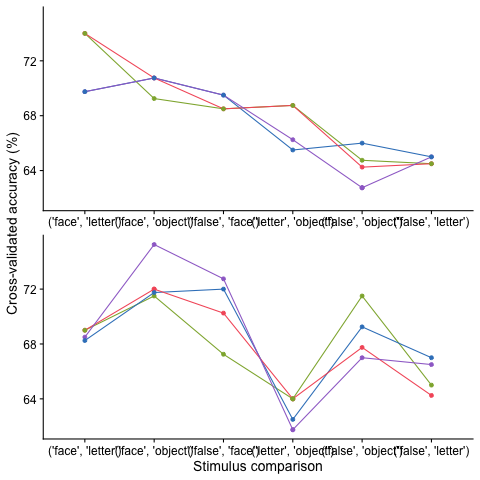

In [20]:
%%R -i averaged_stimulus_type_classification_res -o top_res

# Line plot showing the maximum cross-validated accuracy for each 
# stimulus comparison (x-axis) and meta-ROI pair (colored lines)
top_res <- averaged_stimulus_type_classification_res %>% 
    group_by(meta_ROI_pair, stimulus_combo, Batch_Number) %>% 
    mutate(stimulus_combo = str_replace_all(stimulus_combo, "False", "false")) %>%
    # Find maximum accuracy
    filter(accuracy==max(accuracy,na.rm=T)) %>%
    ungroup() %>%
    mutate(accuracy=100*accuracy,
           stimulus_combo = factor(stimulus_combo, 
                                   levels = c("('face', 'letter')", 
                                              "('face', 'object')",
                                              "('false', 'face')",  
                                              "('letter', 'object')", 
                                              "('false', 'object')", 
                                              "('false', 'letter')"))) 
                                              
top_res %>%
    ggplot(data=., mapping=aes(x=stimulus_combo, y=accuracy, color=meta_ROI_pair, group=meta_ROI_pair)) +
    geom_line() +
    geom_point() + 
    facet_rep_grid(Batch_Number ~ ., repeat.tick.labels=TRUE) +
    xlab("Stimulus comparison") +
    theme(legend.position="none",
          strip.panel.background = element_blank(),
          strip.text = element_blank()) +
    ylab("Cross-validated accuracy (%)") +
    scale_color_manual(values=c("IIT_Category_Selective" = "#9F70CE",
                                "Category_Selective_IIT" = "#3982C4",
                                "Category_Selective_GNWT" = "#8EB03A",
                                "GNWT_Category_Selective" = "#f55c69"))

# ggsave('plots/Max_performance_for_each_stim_combo_by_meta_ROI_pair.svg', width=5.5, height=6, units='in', dpi=300)

## What if we take the SPIs with accuracy > 65% and compare across A) ROI pairs and B) stimulus types?

We are interested in the overlap in the highest-performing SPIs per context, first comparing between meta-ROI pairs and subsequently between stimulus types.

For meta-ROI pairs (4), we can visualize this with an adapted Venn Diagram:

In [25]:
%%R -i averaged_stimulus_type_classification_res -o SPIs_greater_than_65_by_meta_ROI_pair_batch1,IIT_Category_Selective_list_batch1,Category_Selective_IIT_list_batch1,Category_Selective_GNWT_list_batch1,GNWT_Category_Selective_list_batch1

# First, compare across ROI pairs
SPIs_greater_than_65_by_meta_ROI_pair_batch1 <- averaged_stimulus_type_classification_res %>% 
    mutate(accuracy = 100*accuracy) %>%
    filter(Batch_Number == 1) %>%
    dplyr::select(meta_ROI_pair, SPI, accuracy) %>%
    group_by(meta_ROI_pair, SPI) %>% 
    filter(accuracy == max(accuracy)) %>% 
    rowwise() %>%
    filter(accuracy > 65) %>% 
    distinct() %>%
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("IIT_Category_Selective", 
                                                                "Category_Selective_IIT",
                                                                "Category_Selective_GNWT",
                                                                "GNWT_Category_Selective")))

SPIs_greater_than_65_by_meta_ROI_pair_split_batch1 <- split(SPIs_greater_than_65_by_meta_ROI_pair_batch1$SPI, SPIs_greater_than_65_by_meta_ROI_pair_batch1$meta_ROI_pair)
IIT_Category_Selective_list_batch1 <- SPIs_greater_than_65_by_meta_ROI_pair_split_batch1[[1]]
Category_Selective_IIT_list_batch1 <- SPIs_greater_than_65_by_meta_ROI_pair_split_batch1[[2]]
Category_Selective_GNWT_list_batch1 <- SPIs_greater_than_65_by_meta_ROI_pair_split_batch1[[3]]
GNWT_Category_Selective_list_batch1 <- SPIs_greater_than_65_by_meta_ROI_pair_split_batch1[[4]]

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


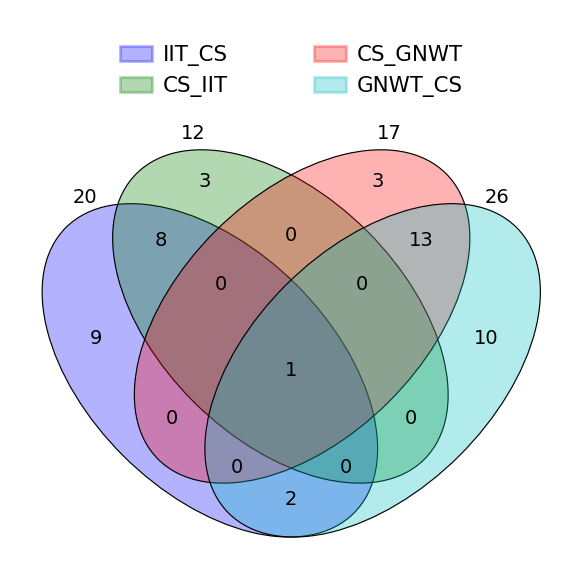

In [26]:
# Venn diagram for meta-ROI pairs
my_sets = {
    'IIT_CS': set(IIT_Category_Selective_list_batch1),
        'CS_IIT': set(Category_Selective_IIT_list_batch1),
        'CS_GNWT': set(Category_Selective_GNWT_list_batch1),
        'GNWT_CS': set(GNWT_Category_Selective_list_batch1)
}

venny4py(sets = my_sets, out="plots/", ext="svg", dpi=300)

In [30]:
%%R -i averaged_stimulus_type_classification_res -o SPIs_greater_than_65_by_meta_ROI_pair_batch2,IIT_Category_Selective_list_batch2,Category_Selective_IIT_list_batch2,Category_Selective_GNWT_list_batch2,GNWT_Category_Selective_list_batch2
# Batch 2 

# First, compare across ROI pairs
SPIs_greater_than_65_by_meta_ROI_pair_batch2 <- averaged_stimulus_type_classification_res %>% 
    mutate(accuracy = 100*accuracy) %>%
    filter(Batch_Number == 2) %>%
    dplyr::select(meta_ROI_pair, SPI, accuracy) %>%
    group_by(meta_ROI_pair, SPI) %>% 
    filter(accuracy == max(accuracy)) %>% 
    rowwise() %>%
    filter(accuracy > 65) %>% 
    distinct() %>%
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("IIT_Category_Selective", 
                                                                "Category_Selective_IIT",
                                                                "Category_Selective_GNWT",
                                                                "GNWT_Category_Selective")))

SPIs_greater_than_65_by_meta_ROI_pair_split_batch2 <- split(SPIs_greater_than_65_by_meta_ROI_pair_batch2$SPI, SPIs_greater_than_65_by_meta_ROI_pair_batch2$meta_ROI_pair)
IIT_Category_Selective_list_batch2 <- SPIs_greater_than_65_by_meta_ROI_pair_split_batch2[[1]]
Category_Selective_IIT_list_batch2 <- SPIs_greater_than_65_by_meta_ROI_pair_split_batch2[[2]]
Category_Selective_GNWT_list_batch2 <- SPIs_greater_than_65_by_meta_ROI_pair_split_batch2[[3]]
GNWT_Category_Selective_list_batch2 <- SPIs_greater_than_65_by_meta_ROI_pair_split_batch2[[4]]

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


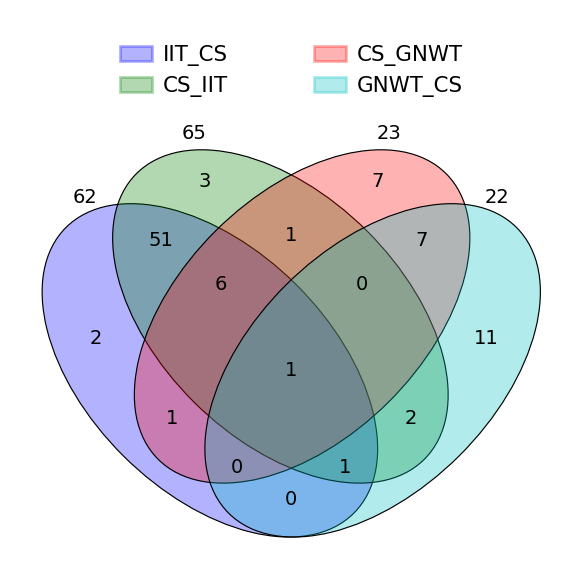

In [31]:
# Venn diagram for meta-ROI pairs
my_sets = {
    'IIT_CS': set(IIT_Category_Selective_list_batch2),
        'CS_IIT': set(Category_Selective_IIT_list_batch2),
        'CS_GNWT': set(Category_Selective_GNWT_list_batch2),
        'GNWT_CS': set(GNWT_Category_Selective_list_batch2)
}

venny4py(sets = my_sets, out="plots/", ext="svg", dpi=300)

## What type(s) of SPIs perform the best (1) by meta-ROI pair and (2) by stimulus type comparison?

Since each SPI belongs to a particular literature category (e.g., 'spectral' or 'information theory'), we can compare the composition of the top-performing (>65% accuracy) SPIs in each context -- first, by meta-ROI pair:

In [42]:
%%R -i SPIs_greater_than_65_by_meta_ROI_pair_batch1,pyspi_SPI_info 

# A) By meta-ROI pair, stacked bar chart showing the relative composition of SPIs with accuracy > 65%
SPIs_greater_than_65_by_meta_ROI_pair_batch1 %>% 
    left_join(., pyspi_SPI_info %>% mutate(Literature_category = as.factor(Literature_category))) %>% 
        mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = rev(c("IIT_Category_Selective", 
                                                                "Category_Selective_IIT",
                                                                "Category_Selective_GNWT",
                                                                "GNWT_Category_Selective")))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_pair, fill=Literature_category)) +
    geom_bar() +
    coord_flip() +
    xlab("Meta-ROI Pair") +
    scale_fill_discrete(drop=FALSE) +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 65%") +
    theme(legend.position = "bottom")

# ggsave('plots/Meta_ROI_pair_top_SPI_categories_batch1.svg', width=6, height=3.5, units='in', dpi=300)

Joining with `by = join_by(SPI)`


In [41]:
%%R -i SPIs_greater_than_65_by_meta_ROI_pair_batch2,pyspi_SPI_info 

# A) By meta-ROI pair, stacked bar chart showing the relative composition of SPIs with accuracy > 65%
SPIs_greater_than_65_by_meta_ROI_pair_batch2 %>% 
    left_join(., pyspi_SPI_info %>% mutate(Literature_category = as.factor(Literature_category))) %>% 
        mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = rev(c("IIT_Category_Selective", 
                                                                "Category_Selective_IIT",
                                                                "Category_Selective_GNWT",
                                                                "GNWT_Category_Selective")))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_pair, fill=Literature_category)) +
    geom_bar() +
    coord_flip() +
    xlab("Meta-ROI Pair") +
    scale_fill_discrete(drop=FALSE) +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 65%") +
    theme(legend.position = "bottom")

# ggsave('plots/Meta_ROI_pair_top_SPI_categories_batch2.svg', width=6, height=3.5, units='in', dpi=300)

Joining with `by = join_by(SPI)`
